# Periodic kernels, vs non-periodic kernels, vs simple RBF kernels

This notebook aims to compare different Gaussian Process kernels. Choice of kernel is vital to correct application of Gaussian Processes, and data which is periodic is generally modelled on the basis of a periodic kernel. This notebook shows however that this is only important when extrapolating away from the given data. When interpolating, non-periodic kernels and indeed even very simple plain RBF kernels do excellent jobs with no need for the additional complexity and parameters of a periodic kernel.  

<img src='co2/co2 modelled as timeseries - residuals from quadratic+periodic over all years.svg' align='right' width='50%'>

### Mauna Loa $CO_2$ concentration levels

The dataset I will look at is the well-known set of observations of $CO_2$ concentration levels at Mauna Loa, a volcano in Hawaii. This dataset is of vital importance to climate research.   


I've previously modelled this non-stationary time series by decomposing it into a long-term quadratic trend, a seasonal component, plus noise. Noise is the residual from the trend and seasonal components, which can be down to various demographic and economic factors; for example, it would be expected that the global shutdown caused by covid will have slowed the increase in $CO_2$ levels to some degree. See on the right my visualisation of my decomposition:  


The axes displaying the residuals at each stage are equally scaled, so that it can clearly be seen how successive subtraction of components reduces the residual.  

Some useful facts to put this data in context:  

- Prior to the Industrial Revolution, CO2 levels were consistently around 280 ppm for thousands of years of human civilization
- Carbon dioxide measured at NOAA’s Mauna Loa Observatory peaked for 2022 at 421 parts per million in May, so has continued rising over the last three years.

[source 1](https://www.noaa.gov/news-release/carbon-dioxide-now-more-than-50-higher-than-pre-industrial-levels), [source 2](https://research.noaa.gov/article/ArtMID/587/ArticleID/2764/Coronavirus-response-barely-slows-rising-carbon-dioxide).  

While this approach of decomposing the data into several components proved itself in making predictions, approaching this using Gaussian Processes allows a new and vital aspect of forecasting to be considered - confidence levels. Since Gaussian Processes model observations as Random Variables, we can compute not only their Expected Value (prediction), but also the Variance of the predictions, an indication of how confident we are in them.  

This dataset is a standard example of data with a very strong seasonal component. As such it is a good choice for comparing periodic kernels to non-periodic kernels, and to a simple RBF kernel. Furthermore, with this dataset the periodic element is clearly on a 12-month basis, it is seasonal - generally even when it is clear that there is a periodic element, their periodicity can still be ambiguous.  

The purpose of a kernel is to encapsulate beliefs about which observations are most related, by giving them a greater covariance. In the case of the RBF kernel, this is done only on the basis of distance between any two points, with closer points having greater covariance. In periodic kernels, this is also done on the basis of whether the two points are at the same position within the period. So for this $CO_2$ data, an observation from June 1990 will have greater covariance to that of June 1995 than it will to that of December 1994.  

In [1]:
# this notebook is run by other notebooks. When this happens, we don't want all outputs produced to be displayed.
# When other notebooks run this one, they create the __file__ variable. So this can be used to test for that.

run_all_examples_display_all_outputs = '__file__' not in locals()       
run_all_examples_display_all_outputs

True

In [2]:
import pandas as pd 
import numpy as np

#requires ipympl to be installed
%matplotlib widget      

import matplotlib.pyplot as plt
import matplotlib

# for creating the models
import sklearn
import sklearn.datasets             #CO2 example
import sklearn.model_selection      #test-train split
import sklearn.gaussian_process
import sklearn.metrics              #RMSE

# for persisting the fitted models
import pickle
import bz2

import IPython.display

The GP models and dataset with predictions are saved locally in the `co2` folder after the first time this notebook is run, so that subsequent runs can simply load them:

In [3]:
# fitting the various GP models takes a few mins, so load from pickle if possible

try:
    # load GP models
    with bz2.open('co2/co2_all_GPs.pkl.pbz2', 'rb') as file:
        all_GPs = pickle.load(file)
    GP_CO2_periodic     = [item['GP'] for item in all_GPs if item['kernel_name']=='periodic'][0]
    GP_CO2_non_periodic = [item['GP'] for item in all_GPs if item['kernel_name']=='non-periodic'][0]
    GP_CO2_simpleRBF    = [item['GP'] for item in all_GPs if item['kernel_name']=='simple RBF'][0]
    
    # load dataset with predictions
    co2_data_all = pd.read_csv('co2\co2.csv')
    co2_data_all['date'] = pd.to_datetime(co2_data_all['date'])
    co2_data_all = co2_data_all.set_index('date')
    
    co2_data_train = co2_data_all[co2_data_all['subset']=='train']
    co2_data_test_extrap = co2_data_all[co2_data_all['subset']=='test_extrap']
    co2_data_test_interp = co2_data_all[co2_data_all['subset']=='test_interp']

    fit_from_scratch=False

# if no pickle/csvs found to load, proceed with notebook: fit the models, and pickle them for next time, and save csvs
except FileNotFoundError:
    fit_from_scratch=True
    
fit_from_scratch

False

#### Retrieve data

The data is available on OpenML at https://www.openml.org/search?type=data&status=active&id=41187&sort=runs, described as:  
> Weekly carbon-dioxide concentration averages derived from continuous air samples for the Mauna Loa Observatory, Hawaii, U.S.A.  


In [4]:
if fit_from_scratch:
    # https://www.openml.org/search?type=data&status=active&id=41187
    co2 = sklearn.datasets.fetch_openml(name='mauna-loa-atmospheric-co2', version=1, # data_id=41187, 
        as_frame=True, parser="pandas")

    #display brief dataset description
    dataset_description_first_line = co2.DESCR[:co2.DESCR.find('<br>')]  #co2.DESCR[:co2.DESCR.find('; ')]
    if run_all_examples_display_all_outputs:
        IPython.display.display(IPython.display.HTML(dataset_description_first_line))

    co2_data = co2.frame
    co2_data['date'] = pd.to_datetime(co2_data[['year', 'month', 'day']])
    # co2_data["date_2"] = co2_data["year"] + (co2_data["date"] - co2_data["date"].year) / pd.Timedelta(1, unit='year')
    co2_data = co2_data[['date', 'co2']].set_index('date')
    co2_data['date_2'] = co2_data.index.year + (co2_data.index.day_of_year / (co2_data.index.is_leap_year + 365))

    co2_data_train, co2_data_test_extrap = sklearn.model_selection.train_test_split(co2_data, train_size=0.7, random_state=0, shuffle=False)
    co2_data_train, co2_data_test_interp = sklearn.model_selection.train_test_split(co2_data_train, train_size=0.7, random_state=0, shuffle=True)

    co2_data_train['subset']='train'
    co2_data_test_extrap['subset']='test_extrap'
    co2_data_test_interp['subset']='test_interp'

    co2_data_all = pd.concat([co2_data_train, co2_data_test_extrap, co2_data_test_interp]).sort_index()

if run_all_examples_display_all_outputs:
    IPython.display.display(co2_data_all)



,co2,date_2,subset,GP_CO2_periodic_preds,GP_CO2_periodic_std,GP_CO2_non-periodic_preds,GP_CO2_non-periodic_std,GP_CO2_simple RBF_preds,GP_CO2_simple RBF_std
date,,,,,,,,,
1958-03-29,316.1,1958.241096,train,316.100040,0.004472,316.343530,0.428575,316.279117,0.394106
1958-04-05,317.3,1958.260274,test_interp,316.684483,0.347308,316.653698,0.400076,316.627163,0.366875
1958-04-12,317.6,1958.279452,test_interp,317.102321,0.346595,316.940346,0.386839,316.974905,0.362602
1958-04-19,317.5,1958.298630,train,317.499980,0.004472,317.192574,0.381688,317.266172,0.363886
1958-04-26,316.4,1958.317808,test_interp,317.537608,0.343586,317.400867,0.379754,317.466208,0.373069
...,...,...,...,...,...,...,...,...,...
2001-12-01,370.3,2001.917808,test_extrap,373.571615,2.300683,368.674203,4.729358,331.062534,7.491956
2001-12-08,370.8,2001.936986,test_extrap,373.890087,2.304774,368.695478,4.735966,331.062534,7.491956
2001-12-15,371.2,2001.956164,test_extrap,374.187232,2.308849,368.716735,4.742584,331.062534,7.491956


#### Plot data


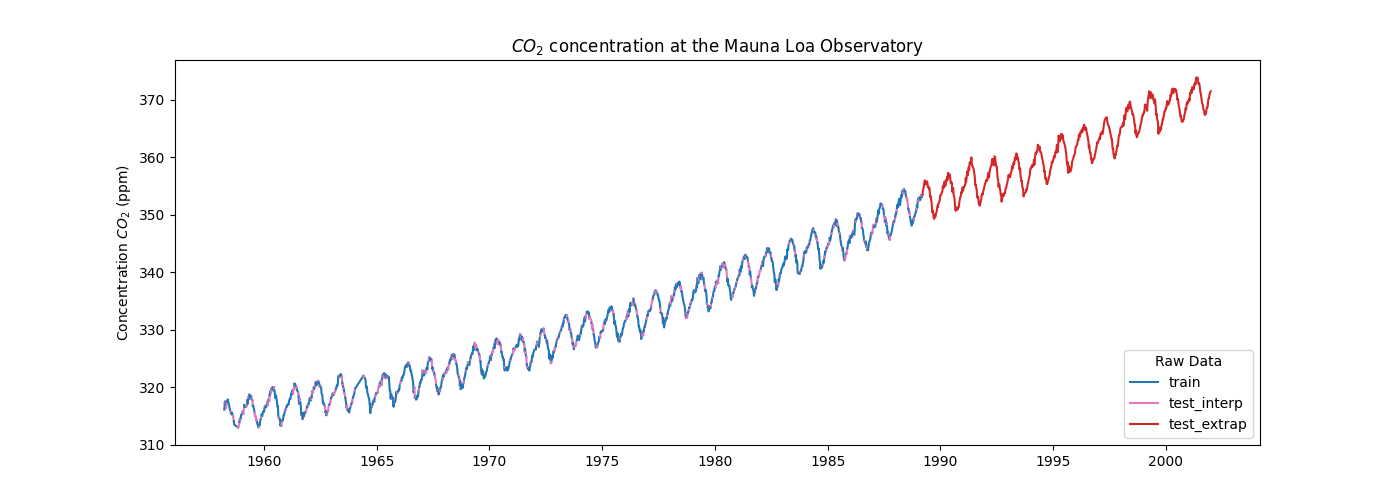

In [5]:
if run_all_examples_display_all_outputs:
        
    fig, ax = plt.subplots(figsize=(14,5))

    #this plot looks better as a line plot than as a scatter plot
    #in order to make a line plot with different colours for train, test_interp, and test_extrap, we must split the df into segments
    #each segment is a set of consecutive observations which are all in the same subset, e.g. all in test_interp
    #then, each segment is plotted as a line with the corresponding colour.
    #When subset changes, the colour depends on the previous observation; colour only changes after subset changes. 
    #  so between a 'train' observation and a 'test' observation, the line colour will be blue.

    # first identify where the data changes from one segment to another (e.g. from train to test_interp):
    segment_changes_idxs = co2_data_all.index[(co2_data_all.subset != co2_data_all.subset.shift(1))].tolist()
    segment_changes_idxs.append(co2_data_all.index[-1])

    # then plot all segments, giving segments colour according to subset type, and setting labels for the legend
    existing_labels=[]
    for i in range(1, len(segment_changes_idxs)):
        segment_subset_type = co2_data_all.subset[segment_changes_idxs[i-1]]
        if   segment_subset_type=='train'       : colour = 'tab:blue' 
        elif segment_subset_type=='test_interp' : colour = 'tab:pink' 
        elif segment_subset_type=='test_extrap' : colour = 'tab:red' 
        plot_line = plt.plot(co2_data_all.co2[segment_changes_idxs[i-1] : segment_changes_idxs[i] ],
            c=colour)

        # we only want to set a label once - otherwise the legend will have an entry for every single segment, mostly repeated
        if segment_subset_type not in existing_labels:
            plot_line[0].set_label(segment_subset_type)
            existing_labels.append(segment_subset_type)

    plt.ylabel("Concentration $CO_2$ (ppm)")
    plt.title("$CO_2$ concentration at the Mauna Loa Observatory")

    plt.legend(loc='lower right', title='Raw Data')

    plt.show()

### Fitting the kernels

We can now fit the GPs using the various kernels. Gaussian Processes are referred to as *non-parametric* models, although this can be misleading - GPs certainly have hyperparameters, such as magnitude, lengthscale and periodicity, which we will be estimating in this section. These parameters are used in the calculation of covariance matrices between the training data and predictions, so these are vital. They are called non-parametric models in contrast to models like time series, where we are deriving those parameters which are explicitly used as the coefficients of the model; with GPs, the hyperparameters trained aren't explicit in the prediction, their involvement is more indirect as they are used in calculating the covariance matrix.

Before fitting, let us first define some building blocks which can be used to compose more complex kernels. (Valid kernels can always be multiplied or added to other valid kernels, and the result will also be a valid kernel). 

Note that the seasonal kernel below has a fixed periodicity of 1 year. This dataset affords us the luxury of knowing what the period length is, so it doesn't need to be estimated.   
The seasonal kernel is multiplied by an RBF kernel (with a very long lengthscale!), to take into account that the strength of the periodic effect can vary over long times.

In [6]:
mean_co2_train = co2_data_train.co2.mean()

if fit_from_scratch:
    
    long_term_trend_kernel = 50.0**2 * sklearn.gaussian_process.kernels.RBF(length_scale=50.0)

    seasonal_kernel = ( 2.0**2 * sklearn.gaussian_process.kernels.RBF(length_scale=100.0) *
        sklearn.gaussian_process.kernels.ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed") )

    irregularities_kernel = 0.5**2 * sklearn.gaussian_process.kernels.RationalQuadratic(length_scale=1.0, alpha=1.0)

    noise_kernel = (0.1**2 * sklearn.gaussian_process.kernels.RBF(length_scale=0.1) + 
        sklearn.gaussian_process.kernels.WhiteKernel(noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)  )  )


    all_GPs = []


#### Kernel #1: Periodic

An explanation of how the periodic kernel is built from the above building blocks is provided later in this notebook, after fitting has been performed and optimal parameters calculated.

For further discussion of this, see [Chapter 5](https://gaussianprocess.org/gpml/chapters/RW5.pdf) of the canonical C. E. Rasmussen & C. K. I. Williams, Gaussian Processes for Machine Learning, the MIT Press, 2006, p.118 onwards, which is the source for the build of this first kernel; and [scikit-learn documentation](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html). 

In [7]:
if fit_from_scratch:
 
    kernel_name = 'periodic'

    CO2_periodic_kernel = long_term_trend_kernel + seasonal_kernel + irregularities_kernel + noise_kernel
    if run_all_examples_display_all_outputs:
        IPython.display.display(CO2_periodic_kernel)


    GP_CO2_periodic = sklearn.gaussian_process.GaussianProcessRegressor(kernel=CO2_periodic_kernel, normalize_y=False)
    GP_CO2_periodic.fit(X=co2_data_train.date_2.to_numpy().reshape(-1, 1), 
        y=co2_data_train.co2 - mean_co2_train)
    if run_all_examples_display_all_outputs:
        IPython.display.display(GP_CO2_periodic)


    co2_data_all['GP_CO2_'+kernel_name+'_preds'], co2_data_all['GP_CO2_'+kernel_name+'_std'] = GP_CO2_periodic.predict(
        co2_data_all.date_2.to_numpy().reshape(-1, 1),
        return_std=True
        )
    co2_data_all['GP_CO2_'+kernel_name+'_preds'] += mean_co2_train
    # IPython.display.display(co2_data_all)

    all_GPs.append({'kernel_name': kernel_name, 'GP':GP_CO2_periodic})


#### Kernel #2: Non-Periodic

This kernel aims to capture long-term trends by having an RBF kernel with a long lengthscale. This should allow the GP to ignore the short-term seasonal component, as well as any noise, and focus mainly on the general increasing trend.

In [8]:
if fit_from_scratch:
    
    kernel_name = 'non-periodic'

    CO2_non_periodic_kernel = long_term_trend_kernel + irregularities_kernel + noise_kernel
    IPython.display.display(CO2_non_periodic_kernel)


    GP_CO2_non_periodic = sklearn.gaussian_process.GaussianProcessRegressor(kernel=CO2_non_periodic_kernel, normalize_y=False)
    GP_CO2_non_periodic.fit(X=co2_data_train.date_2.to_numpy().reshape(-1, 1), 
        y=co2_data_train.co2 - mean_co2_train)
    if run_all_examples_display_all_outputs:
        IPython.display.display(GP_CO2_non_periodic)


    co2_data_all['GP_CO2_'+kernel_name+'_preds'], co2_data_all['GP_CO2_'+kernel_name+'_std'] = GP_CO2_non_periodic.predict(
        co2_data_all.date_2.to_numpy().reshape(-1, 1),
        return_std=True
        ) 
    co2_data_all['GP_CO2_'+kernel_name+'_preds'] += mean_co2_train
    # IPython.display.display(co2_data_all)

    all_GPs.append({'kernel_name': kernel_name, 'GP':GP_CO2_non_periodic})


#### Kernel #3: Simple RBF

This kernel aims to only capture short term similarities, and completely ignores long-term trends. Thus an RBF kernel is used with a very short lengthscale of 3 months. As there is no long-term component, this will give rise to a **stationary** covariance function, which only depends on the distance in time between two datapoints, and not on the time itself.

This is the simplest of all three models. The question we are addressing is to what extent this simplicity detracts from predictions.

I hypothesise as follows. **Extrapolations** will certainly be terrible with this kernel: covariance is a function of distance only, so for dates far from those in the training set, covariance with the training observations will be practically zero, and therefore predictions will basically equal the training data mean. However we expect that **interpolations** over short gaps will be almost as good as the more complex versions above; since the gaps are small, there is low distance to the nearest points, and therefore high covariance, so those nearest datapoints can be used to inform predictions.

In [9]:
if fit_from_scratch:
    
    kernel_name = 'simple RBF'

    CO2_simpleRBF_kernel = (sklearn.gaussian_process.kernels.ConstantKernel(co2_data_train.co2.std()**2) * 
        sklearn.gaussian_process.kernels.RBF(length_scale=3/12, length_scale_bounds='fixed')  + noise_kernel)
    if run_all_examples_display_all_outputs:
        IPython.display.display(CO2_simpleRBF_kernel)


    GP_CO2_simpleRBF = sklearn.gaussian_process.GaussianProcessRegressor(kernel=CO2_simpleRBF_kernel, normalize_y=False)
    GP_CO2_simpleRBF.fit(X=co2_data_train.date_2.to_numpy().reshape(-1, 1), 
        y=co2_data_train.co2 - mean_co2_train)
    if run_all_examples_display_all_outputs:
        IPython.display.display(GP_CO2_simpleRBF)


    co2_data_all['GP_CO2_'+kernel_name+'_preds'], co2_data_all['GP_CO2_'+kernel_name+'_std'] = GP_CO2_simpleRBF.predict(
        co2_data_all.date_2.to_numpy().reshape(-1, 1),
        return_std=True
        ) 
    co2_data_all['GP_CO2_'+kernel_name+'_preds'] += mean_co2_train

    all_GPs.append({'kernel_name': kernel_name, 'GP':GP_CO2_simpleRBF})


### Visualise GPs

Now that the 3 GPs have been fitted, we can visualise their fits on the entire dataset, including the test-interpolations and test-extrapolations. 

#### Coefficient of Determination / `score`
On the graph below, in the legend, a `score` is given for each GP. This score is the "coefficient of determination", $R^2$:  

$$R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i-\hat{y_i}_{\text{GP}})^2} {\sum_{i=1}^{n} (y_i-\bar{y}_{\text{mean}})^2} $$

where $ \hat{y_i}_{\text{GP}} $ is the prediction made by the Gaussian Process, and $\bar{y}_{\text{mean}} $ is the mean of the *test* data.  

> 
> It is worth explaining what is happening here as sometimes people get confused with this:  
> 
> Examining this formula, we see that the top of the fraction is SSE - Sum of Squared Errors - between the GP prediction and reality. The bottom of the fraction can be considered also to be the SSE between *using the data mean as prediction* and reality. In other words, without GPs or any form of regression, the best prediction we would be able to give for the test data would be the mean of the data. And the bottom of the fraction measures how good a prediction that is.  
> 
> Now when the GP predictions are spot on, the top of the fraction will be $0$ - no error. So $R^2$ will be $1$ - this is the best coefficient of determination possible.  
> 
> In a more realistic scenario, there is some error. So what the fraction is doing is comparing the error given by the GP, to the error we would get if we used the much less sophisticated method of just using the mean. The smaller the fraction, the better the GP predictions are compared to the prediction of just using the mean. If the GP is no better than the mean, then the fraction will equal $1$ so $R^2$ will equal $0$.  
> 
> However there is a third scenario, in which the GP actually performs *worse* than using the test data mean. In that case, the top of the fraction is bigger than the bottom, and the fraction is greater than $1$. It can be arbitrarily bigger, as the GP can be really bad, and so the fraction can be as high as $\infty$. So the lowest value $R^2$ can take is $- \infty$.  
> 
> In summary: 
> - If $R^2$ is close to $1$, the GP has performed excellently compared to using the test data mean.
> - If $R^2$ is close to $0$, the GP has not performed much better than simply using the mean.
> - If $R^2$ is negative, the GP has performed worse than simply using the mean; the more negative, the worse.
> 

Bearing that in mind, let us examine the graph and the coefficients of determination for each of the GPs.

In [10]:
def draw_data_GPs(data, all_GPs, kernels_legend_location='upper left'):

    co2_data_train = data[data['subset']=='train']
    co2_data_test_extrap = data[data['subset']=='test_extrap']
    co2_data_test_interp = data[data['subset']=='test_interp']
    data_subsets = set(data.subset)

    fig, ax = plt.subplots(figsize=(14,8))

    scatter_kwargs = {'s':1, 'alpha':0.75, }
    scatter1 = plt.scatter(co2_data_train.index, co2_data_train.co2, c='tab:blue', label='train data', **scatter_kwargs, )
    scatter2 = plt.scatter(co2_data_test_interp.index, co2_data_test_interp.co2, c='tab:pink', label='test (interpolation) data', **scatter_kwargs, )
    scatter3 = plt.scatter(co2_data_test_extrap.index, co2_data_test_extrap.co2, c='tab:red', label='test (extrapolation) data', **scatter_kwargs, )

    # ylim = plt.ylim()

    line_kwargs = {'alpha':0.7, 'lw':.75, }#'ls':'-', }
    fill_between_kwargs = {'alpha':0.075, }

    GP_lines=[]
    if len(data)<=250:  
        artificial_data = pd.DataFrame(index=pd.date_range(start=data.index.min(), end=data.index.max(), periods=500))
        artificial_data['date_2'] = artificial_data.index.year + (artificial_data.index.day_of_year / (artificial_data.index.is_leap_year + 365))

    for i, GP in enumerate(all_GPs):
        # print(GP)
        label_thisGP = ('predictions using ' + GP['kernel_name'] + ' kernel:\n ' + 
            str(GP['GP'].kernel_).replace(' + ', '\n   + ') )

        if ('test_interp' in data_subsets) or ('test_extrap' in data_subsets):
            label_thisGP += '\n'
        if 'test_interp' in data_subsets:
            label_thisGP += (' Score on test-interpolation data in plot: ' + 
                str(GP['GP'].score(co2_data_test_interp.date_2.to_numpy().reshape(-1, 1), co2_data_test_interp.co2 - mean_co2_train ).round(5)) )
        if ('test_interp' in data_subsets) and ('test_extrap' in data_subsets):
            label_thisGP += '    ***  '
        if 'test_extrap' in data_subsets:
            label_thisGP += (' Score on test-extrapolation data in plot: ' + 
                str(GP['GP'].score(co2_data_test_extrap.date_2.to_numpy().reshape(-1, 1), co2_data_test_extrap.co2 - mean_co2_train ).round(5))  )
            
        colour = ["tab:green", 'tab:olive', 'tab:cyan'][i]
        if len(data)>250:
            GP_line_pred_data = data['GP_CO2_'+GP['kernel_name']+'_preds']
            GP_fill_std_data  = data['GP_CO2_'+GP['kernel_name']+'_std']
        else:
            
            artificial_data['GP_CO2_'+GP['kernel_name']+'_preds'], artificial_data['GP_CO2_'+GP['kernel_name']+'_std'] = GP['GP'].predict(
                    artificial_data.date_2.to_numpy().reshape(-1, 1),        return_std=True        ) 
            artificial_data['GP_CO2_'+GP['kernel_name']+'_preds']  += mean_co2_train
            GP_line_pred_data = artificial_data['GP_CO2_'+GP['kernel_name']+'_preds']
            GP_fill_std_data  = artificial_data['GP_CO2_'+GP['kernel_name']+'_std']


        line, = plt.plot(GP_line_pred_data, c=colour, label=label_thisGP, **line_kwargs) 
        GP_lines.append(line)
        plt.fill_between(x=GP_line_pred_data.index, 
            y1=GP_line_pred_data - GP_fill_std_data,            y2=GP_line_pred_data + GP_fill_std_data,
            color=colour , **fill_between_kwargs,)

    line_h = plt.hlines(mean_co2_train, xmin=data.index.min(), xmax=data.index.max(), 
        colors='tab:gray', ls=':', label='train data mean', alpha=.5)
    GP_lines.append(line_h)

    # plt.ylim(ylim)

    plt.ylabel("$CO_2$ concentration (ppm)")
    plt.title("$CO_2$ concentration at the Mauna Loa Observatory")

    ax.add_artist(plt.legend(handles=GP_lines, loc=kernels_legend_location, fontsize='small', title='Predictions made using GPs with various kernels'))
    ax.add_artist(plt.legend(handles=[scatter1, scatter2, scatter3], loc='lower right', title='Raw Data'))

    plt.show()



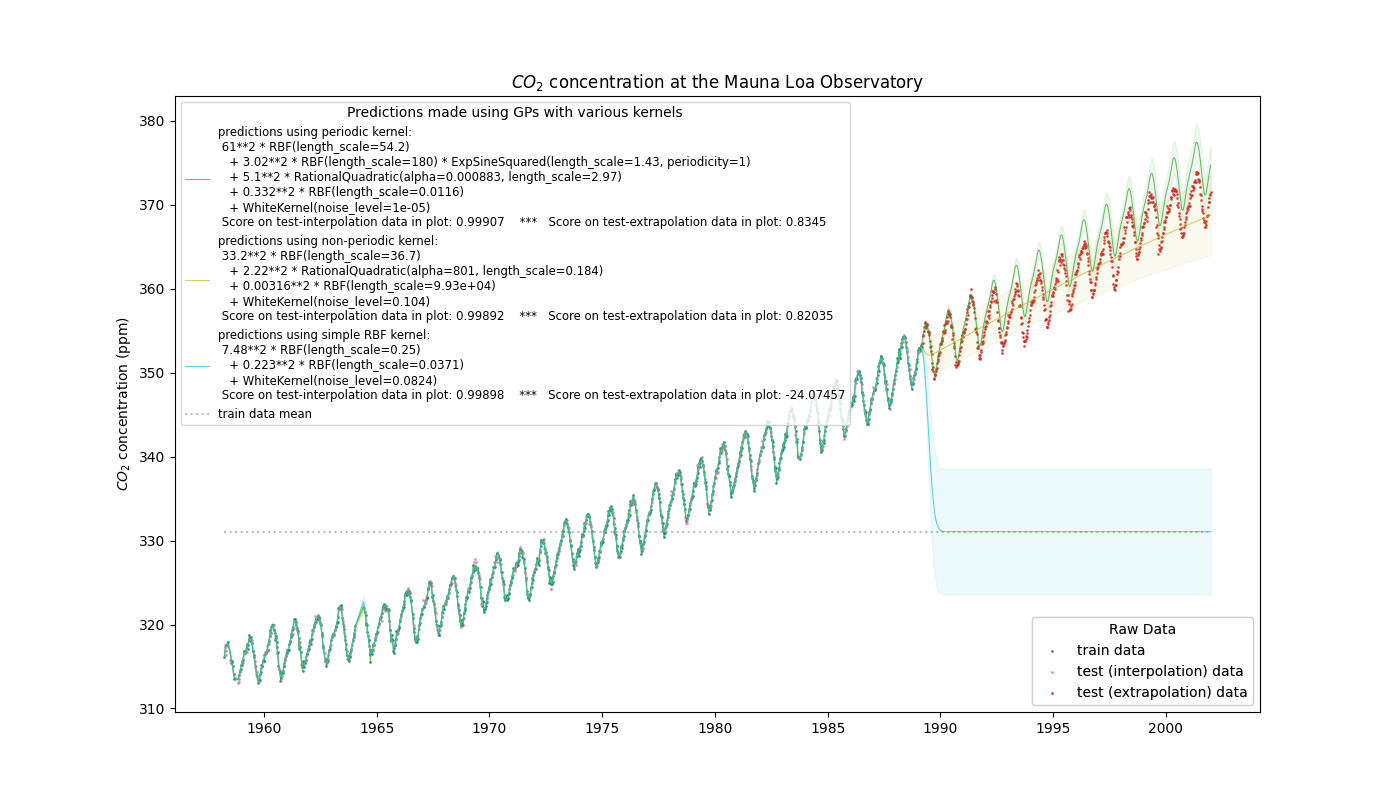

In [11]:
if run_all_examples_display_all_outputs:
    draw_data_GPs(data=co2_data_all, all_GPs=all_GPs)

#### Extrapolation
Visually, the green line for the periodic kernel is the best extrapolation, being closest to the red dots of the test-extrapolation dataset. The confidence region for this GP increases as we move away from the training data, but remains relatively narrow.  

The yellow line for the non-periodic kernel is second best. This kernel has done a fairly good job of capturing the long term trend in the data, but has obviously not captured the seasonal component. 

The blue line for the simple RBF kernel performs really poorly here. Given that the lengthscale is only 3 months (0.25 years), soon after leaving the training dataset the predictions have negligible covariance with any of the observations. As a result, the predictions revert to simply being the mean of the *training* data, which is very poor for this test data. Attempting to model a very non-stationary dataset with a stationary covariance matrix leads to failure when extrapolating.

These visual conclusions are backed up by looking at the scores, recorded in the legend. For extrapolation, the periodic kernel has the CoD which is closest to $1$ at $0.8345$, an impressive result given the extrapolation is over 15 years outside the training dataset. But the non-periodic kernel does almost as well, getting $0.82035$. Whereas the simple RBF captures neither the periodicity nor the long term trend, and reverts to the *training* mean, so is a far worse prediction than using the *test* mean would be. As a result, this kernel gets a very negative CoD.





#### Interpolation

Visually, the three lines for the periodic, non-periodic, and simple RBF kernels are virtually indistinguishable. All three kernels perform really well for interpolation. 

These visual conclusions are backed up by looking at the scores on interpolation data, also recorded in the legend. The three kernel all have CoDs which are extremely close to $1$ at $0.999$. This supports our hypothesis that for interpolation over short distances, the three kernels would all perform comparably.  

The explanation is that for interpolation, we are attempting to model very short-term fluctuations between consecutive observations. A kernel which fully understands long-term trends will be none the wiser regarding short term fluctuations. 

In fact it would be impossible to extract any insight about short-term fluctuations from the data: all observations are one week apart, so to model what happens over the week would require more frequent readings. 

If for example we had one year of *daily* readings, we could see perhaps that over the weekend $CO_2$ levels are different; if we had *hourly* readings over that year, we could get insight about how $CO_2$ levels change at night. We could then use that data to inform interpolations within the other years of the dataset. However we don't have such readings: all data is spaced at weekly intervals. Given the limitations of our dataset, interpolation can be performed comparatively accurately only on the basis of the nearest observations, and cannot be improved significantly by looking at long-term data.



### Overfitting  

Zooming in on a small section of the data with the GP predictions is instructive:  

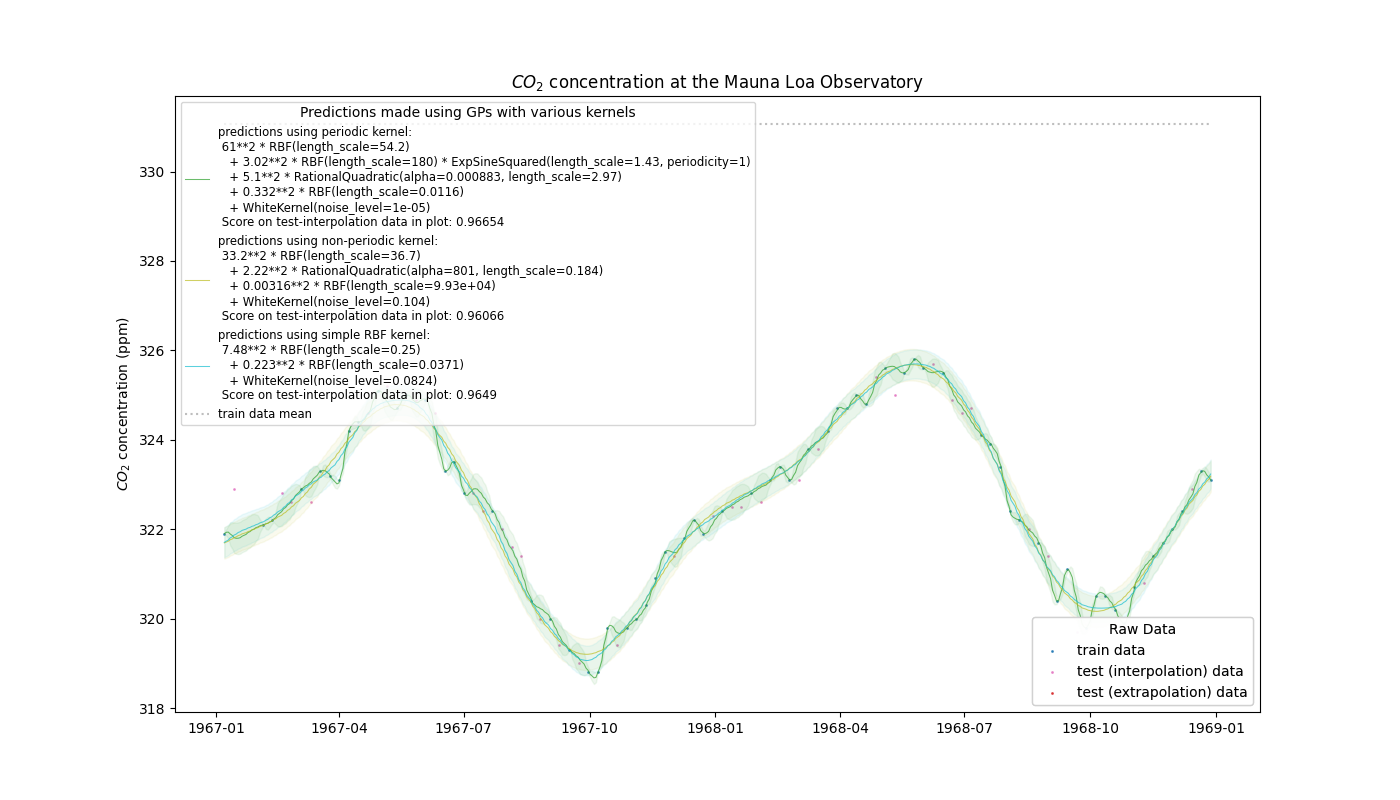

In [12]:
if run_all_examples_display_all_outputs:
    draw_data_GPs(data=co2_data_all[(1967<co2_data_all.date_2) & (co2_data_all.date_2<1969)], all_GPs=all_GPs)

This plot shows that the green line is very jagged and very sensitive to changes in the data in trying to get the best fit. Whereas the yellow and blue lines are much smoother. The scores on the test-interpolation data shows that the added complexity in the green line doesn't translate to significantly better predictions.  

This is a pretty strong indication that the green line is overfitting on the training data. But I'd argue that isn't necessarily a bad thing here! 

#### Why the overfitting happened in the periodic kernel
Let's look at why the overfitting happened. Looking at the kernels in the legend of the plot, the kernel for the green line has the following components:  
- RBF with length scale $54.2$. This is what captures the long term trend, as this length scale spans over 50 years.  
- an ExpSineSquared multiplied by an RBF. This captures the periodic element, as the ExpSineSquared is periodic. The periodicity of the ExpSineSquared is $1.0$, as we know the periodicity is a seasonality so the period is exactly one year.   The purpose of the RBF it is multiplied by is to allow a decay in the periodic element over time, as the periodicity is not necessarily constant over the entire dataset. This RBF has a very long length scale of $180$ years, which means that over the 43 years this dataset covers, the affect of periodicity will not change much.
- a Rational Quadratic kernel (not that different in terms of functionality from an RBF kernel, an RBF could have been used here) with lengthscale $2.97$. This captures medium-term ups and downs which would be missed by the long-term-trend kernel.
- Finally, a noise kernel consisting of an RBF with lengthscale $0.016$ and white noise. The magnitude of this component is small at $0.332$, smaller than all the other kernels, so this will only allow small amounts of noise. 

The reason the overfitting is happening is that the lengthscale is so small on this last noise RBF kernel. A lengthscale of $0.016$ years is less than 6 days! Which means that this noise kernel can't really capture information from more than a week away. As this dataset contains readings of at least a week apart, this kernel will only capture information from the nearest observation and use that to influence predictions. As the magnitude of this kernel is small it can't have a huge difference, but within this dataset that is all it needs.  

So in a nutshell, this RBF "noise kernel" is basically an "overfitting kernel"! It simply learns the data in a very local fashion, and predicts accordingly.  



#### Why overfitting didn't happen in the other kernels
If we look at the other GP prediction lines, the next smallest lengthscale is in the blue "Simple RBF" GP, where the 2nd RBF component has lengthscale $0.0371$. However that is two weeks ($0.0371\times52\approx2$), so it cannot focus exclusively on the nearest point. Also the magnitude of this component is smaller. So no overfitting.  

In the yellow "non-periodic" kernel, the Rational Quadratic appears to have become the noise component with a small lengthscale of $0.184$. This is almost 10 weeks, again too long for overfitting. Interestingly, the RBF component which was supposed to model noise, ended up being an ultra-long-term trend predictor, with a lengthscale of almost $100,000$ years! Obviously that is far too long for our dataset and means all points will have correlation pretty much equally as far as this component is concerned. Because this component now has too long a lengthscale to be useful, its magnitude shrinks down to $0.00316$, so is basically irrelevant. And the Rational Quadratic kernel took its place as modelling something between medium term variations and short term noise.


#### Why specifically the periodic kernel has the overfitting

It isn't coincidental that the periodic kernel has overfitting. The RBF component of the periodic kernel got optimised to have a very short lengthscale, simply because all other major factors (specifically periodicity) are already modelled with the other components of the kernel. So this RBF isn't needed for anything other than short term noise.  

With the other kernels however, periodicity isn't modelled explicitly with a dedicated component. So the periodicity becomes part of "noise" as far as this kernel is concerned, in that it is unexplained by other components. Therefore this final RBF which is supposed to capture noise has to capture periodicity as well. In order to do this, a longer lengthscale is optimal. 

#### Is the overfitting in the periodic kernel bad?
Now rule #1 of function approximation from noisy data is that overfitting is the enemy. Overfitting means that predictions will be unduly influenced by noise in the dataset, when the goal is to capture the real trends without noise. So without thinking too much, one could conclude that this kernel is flawed; and one could suggest that it would be improved by setting a minimum for the lengthscale of perhaps 2-3 weeks which would prevent this overfitting.  

However I believe the truth is that Gaussian processes are somewhat different to other function approximation methods in this regard. With other methods, the further away you go from the training data, the more one would expect the negative effects of overfitting to be evident. For example, fitting a high degree polynomial to data which doesn't justify it. 

##### Illustration of standard overfitting
Here is a quick illustration of overfitting using cubic data. The data $Y$ is drawn from $Y=x^3+3+W$, where $W \sim \mathcal{N}(0,\,3^2)$

 On train data there is a lower MSE for a 15th-order polynomial, yet the 3rd-order polynomial is clearly seen to be better. And on the test data this is confirmed, both visually and by the MSEs:

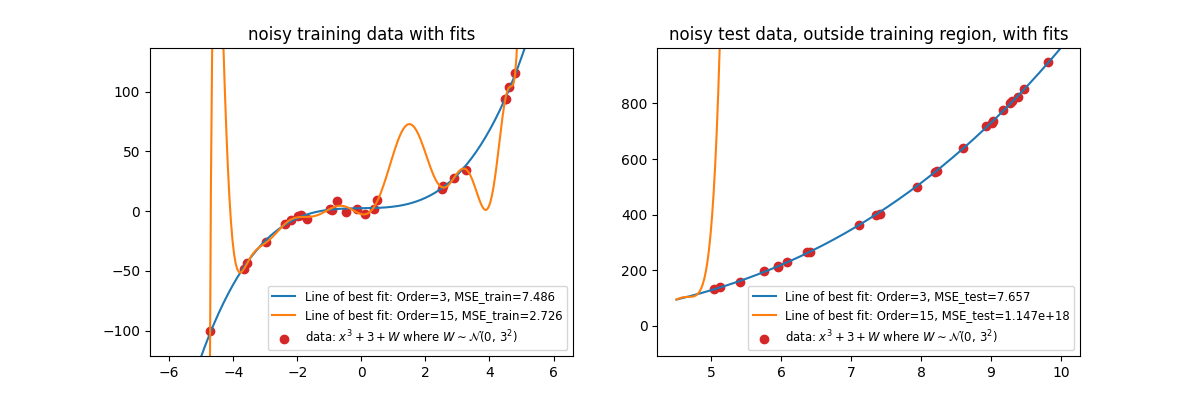

In [13]:
if run_all_examples_display_all_outputs:
    

    rng = np.random.default_rng(1)

    def round_sig(x, sig=3):
        '''rounds x to specified number of significant figures'''
        return np.round(x, sig-np.floor(np.log10(np.abs(x)) ).astype(int) -1)

    # demonstrate above function:
    # x_=np.hstack([rng.uniform(-100000.,100000, 15), rng.uniform(-10.,10, 15) ])
    # print(x_, np.array([round_sig(x_i, sig=3) for x_i in x_]))

    noise_sd = 3

    fig, (ax_train, ax_test) = plt.subplots(ncols=2, figsize=(12,4))
    # x = np.linspace(-5,5,25)
    x_train = rng.uniform(-5.,5.,25)
    y_train = 3 + x_train**3 + rng.normal(loc=0, scale=noise_sd, size=x_train.shape)
    ax_train.scatter(x_train, y_train, c='tab:red', label='data: $x^3+3+W$ where $W \sim \mathcal{N}(0,\,'+str(noise_sd)+'^2)$')
    ylim_train=ax_train.get_ylim()

    x_test = rng.uniform(5.,10.,25)
    y_test = 3 + x_test**3 + rng.normal(0,3,x_test.shape)
    ax_test.scatter(x_test, y_test, c='tab:red', label='data: $x^3+3+W$ where $W \sim \mathcal{N}(0,\,'+str(noise_sd)+'^2)$')
    ylim_test=ax_test.get_ylim()

    x2_train = np.linspace(-6,6,250)
    x2_test = np.linspace(4.5,10,250)
    for order in [3,15]:
        polynomial = np.polyfit(x_train,y_train, order)

        MSE_train = sklearn.metrics.mean_squared_error(y_true=y_train, y_pred=np.polyval(polynomial, x_train))
        ax_train.plot(x2_train, np.polyval(polynomial, x2_train), label=('Line of best fit: Order=' +str(order) + ', MSE_train=' +str(round_sig(MSE_train,4)) ) )#+ ', coeffs='+str(p))

        MSE_test = sklearn.metrics.mean_squared_error(y_true=y_test, y_pred=np.polyval(polynomial, x_test))
        ax_test.plot(x2_test, np.polyval(polynomial, x2_test), label=('Line of best fit: Order=' +str(order) + ', MSE_test=' +str(round_sig(MSE_test,4)) ) )#+ ', coeffs='+str(p))

    ax_train.set_title('noisy training data with fits')
    ax_test.set_title('noisy test data, outside training region, with fits')
    ax_train.set_ylim(ylim_train+np.array([-10,10]))
    ax_test.set_ylim(ylim_test+np.array([-200,10]))
    ax_train.legend(fontsize='small', loc='lower right')#loc='left', bbox_to_anchor=(0.5, -0.05),)
    ax_test.legend(fontsize='small', loc='lower right')#loc='upper center', bbox_to_anchor=(0.5, -0.05),)
    plt.show()

So these plots show how over-sensitivity to training data means learning noise, which means not learning the true function, which means very poor predictions, particularly outside the training data region. The higher order polynomial has a lower MSE on the train data, but extremely high MSE on test data. This demonstrates the perils of overfitting a normal function.  

However with Gaussian Processes, in our particular case, it isn't like that. The overfitting on the training data won't translate to worse predictions in the far away test data. This is because we explained that the overfitting is due to the RBF with the very low lengthscale, which only captures local data. However the same short lengthscale also means that extrapolating to new far away data won't be affected by this RBF component, since it is so far away.  

So essentially this type of overfitting is different to normal overfitting. It allows the model to account for local noise, without letting the extrapolated predictions be negatively impacted. In fact, building some noise-explaining-component into the kernel can allow the rest of the kernel to focus better on the main trends, as noise is explained by the noise component. 

#### Interpolation vs extrapolation

However this argument is only valid for **extrapolation** away from the training data: as the lengthscale is small, the noise component will be irrelevant for extrapolation. **Interpolation** however considers points in between the points of the training data, and as such the noise component can affect interpolations.  

Whether this is desirable or not would depend on our assumptions of what the noise represents and whether we wish to reproduce it in our predictions. For example if it is due to sensor inaccuracy we would probably rather ignore it (unless we are modelling sensor readings). But if we assume the noise is due to some very short-term local factor which affected $CO_2$ readings, e.g. unusual wind currents that week, then we may want that to be incorporated in our interpolation modelling, even though we would want to ignore it for the purposes of extrapolation.  

Here is a plot showing that extrapolation doesn't suffer from the overfitting in our case:  

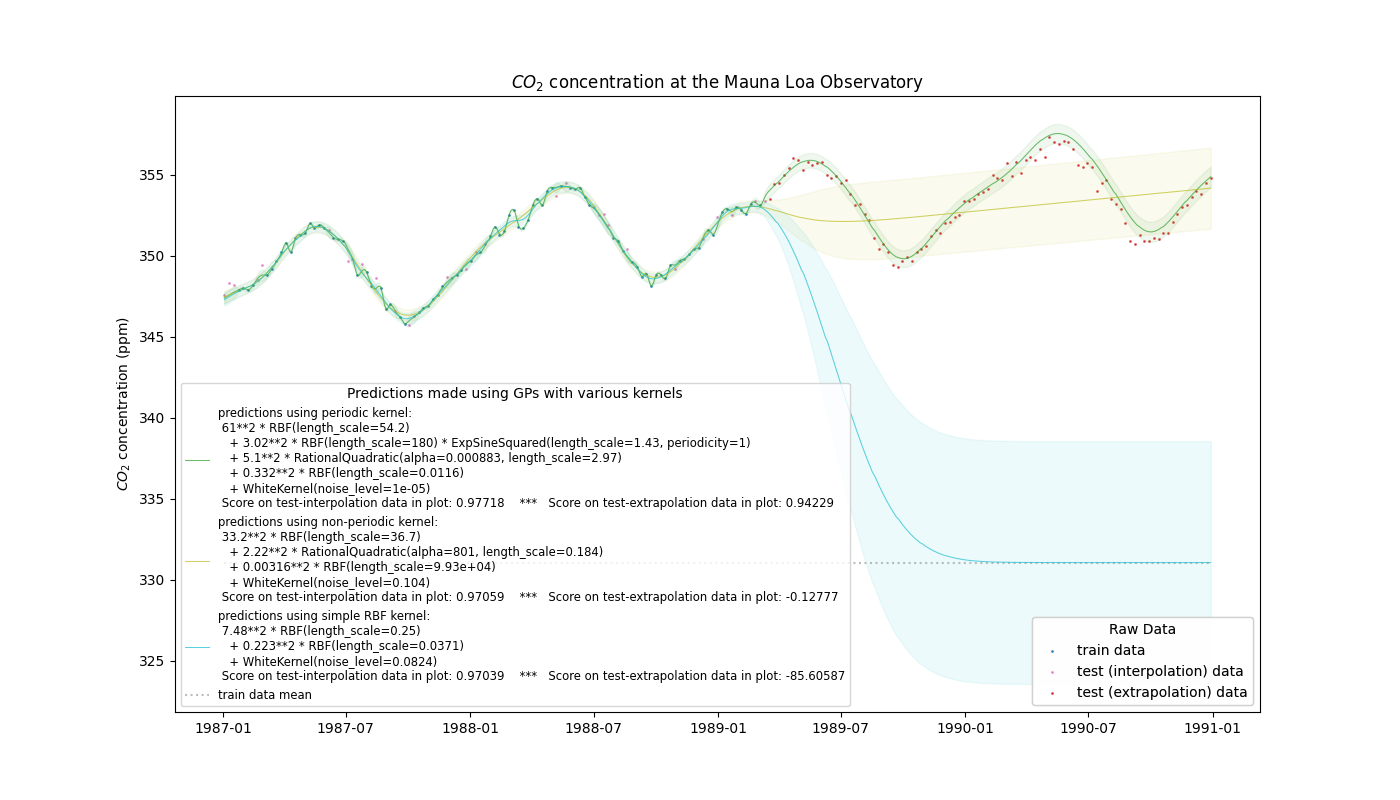

In [14]:
if run_all_examples_display_all_outputs:
    draw_data_GPs(data=co2_data_all[(1987<co2_data_all.date_2) & (co2_data_all.date_2<1991)], all_GPs=all_GPs, kernels_legend_location='lower left')

So the green line is perfectly smooth, the "overfitting" doesn't affect extrapolations. 

The main issue with the green line is that it goes too high. This is because this kernel estimated the long-term trend as being higher than it actually was. Similarly in the next plot, the periodic element is captured well, but the long term trend could be improved. Interestingly, with the yellow line (non-periodic kernel) the long term trend suffers from the opposite issue in that it is too low.

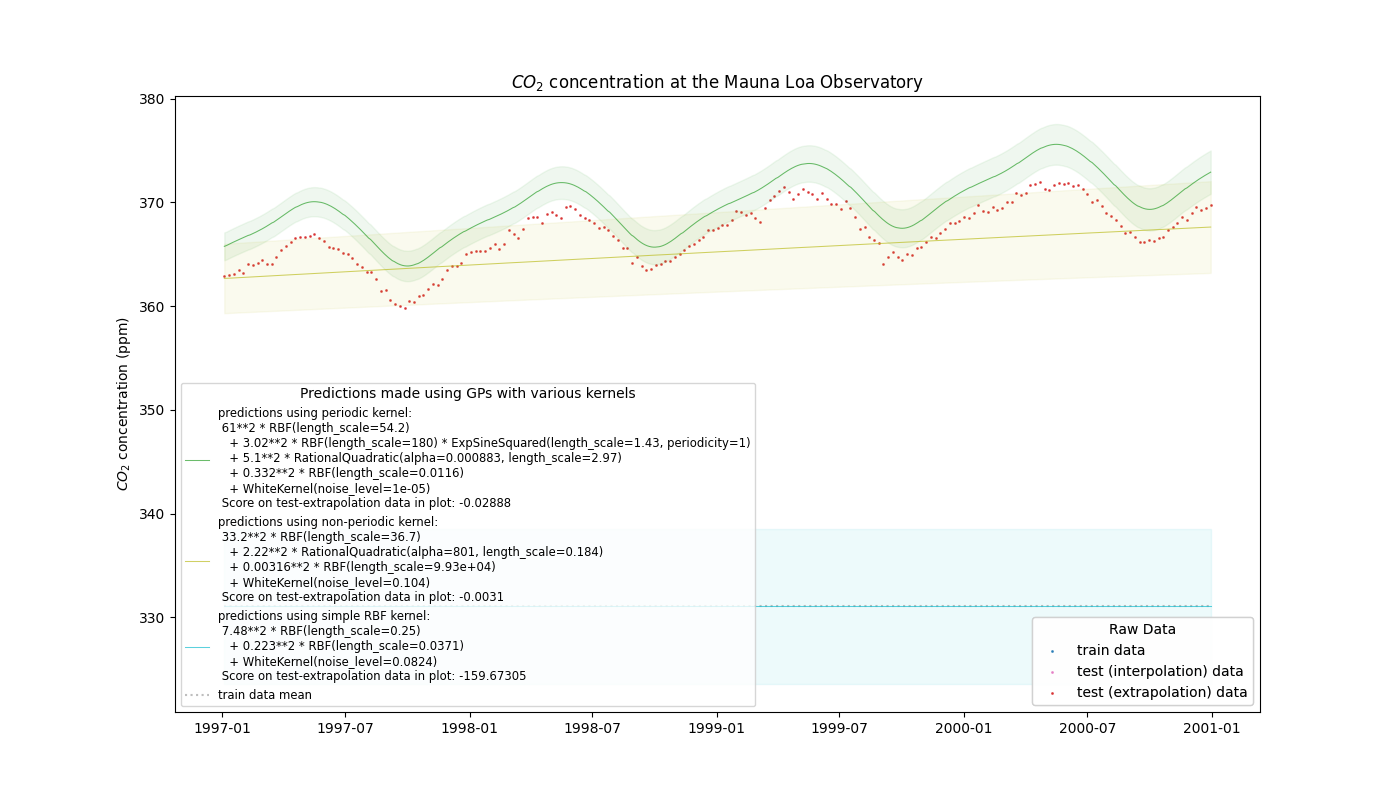

In [15]:
if run_all_examples_display_all_outputs:
    draw_data_GPs(data=co2_data_all[(1997<co2_data_all.date_2) & (co2_data_all.date_2<2001)], all_GPs=all_GPs, kernels_legend_location='lower left')

### Conclusion

**Gaussian Processes** are a useful extension to the toolkit for modelling timeseries. Their main advantage is that since they model predictions as RVs, they have the ability to estimate standard deviation of the distribution of those predictions. This can be used to make confidence regions around the expected value.  

In order to **extrapolate** outside the region of the training data, a lot of care is necessary in specifying the kernel. Kernel specification is like a language we use to communicate to the model what types of relationships we would like estimated within the data. And with extrapolation, an accurate model of those relationships is essential.  

In order to **interpolate** within the data, we've seen that the kernel specification can be very unsophisticated. All we are looking for is a smoothing function which looks at the closest neighbours only. Long-term relationships in the data are unimportant for modelling short term fluctuations between observations; and the rest of the data can't give us any insight into these short term fluctuations.  

Finally, we contrasted overfitting with standard function approximation to **overfitting with Gaussian Processes**. The overfitting caused by a kernel with too short a lengthscale is more benign in that it cannot affect extrapolations, due to the short timescale. It can however affect interpolations, so a simpler kernel may be preferable here. Of course if there is domain knowledge about the nature of these very short-term changes, that they are not irrelevant noise but something worth modelling. In which case, with Gaussian Processes you can get the best of both worlds, by including such a short-term kernel, which will inform interpolations without wreaking havoc on extrapolations. 

In [16]:
# number of years covered by dataset
np.timedelta64((co2_data_all.index.max() - co2_data_all.index.min())).astype('timedelta64[Y]')  #/pd.Timedelta(1,'d') / 365.25

numpy.timedelta64(43,'Y')

In [17]:
# minimum gap between consecutive timestamps in the dataset (days) 
np.min(np.diff(co2_data_all.index)).astype('timedelta64[D]')    #/pd.Timedelta(1,'d')

numpy.timedelta64(7,'D')

After the first run, save the data and Gaussian Processes for next time:

In [18]:
if fit_from_scratch:
    with bz2.open('co2/co2_all_GPs.pkl.pbz2','wb') as file:
        pickle.dump(all_GPs, file)

    co2_data_all.to_csv('co2/co2.csv')
    